# *Задание -1. Импорт данных*


In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-10-09 19:26:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  16.2MB/s    in 13s     

2022-10-09 19:26:51 (15.0 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
y_train = y[:train_size].reshape(-1, 1)
y_test = y[train_size:].reshape(-1, 1)
X_train = X[:train_size, :]
X_test = X[train_size:, :]

# **Задание 0. Предварительный анализ**

Text(0, 0.5, 'Number of songs')

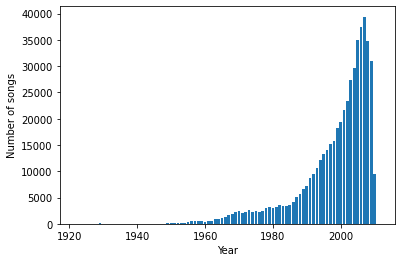

In [ ]:
# Посмотрим распределение песен по годам
nsongs = {}
for i in range(1922,2012):
    nsongs[i] = len(y[y==i])

years = range(1922,2012)
values = [nsongs[z] for z in years]
plt.bar(years, values, align='center')
plt.xlabel("Year")
plt.ylabel("Number of songs")

Как и следовало предположить, большая часть песен выборки вышла в конце 20 века или позднее. При этом разброс значений достаточно велик: около 90 лет. Имеет смысл регуляризовать года.

Text(0, 0.5, 'Value')

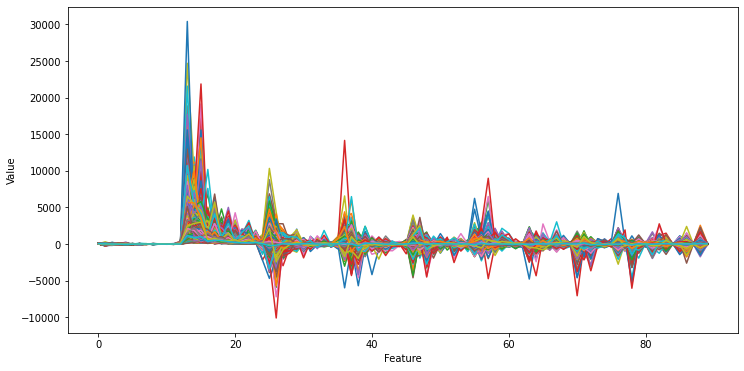

In [ ]:
# посмотрим распределение значений признаков в подвыборке песен
plt.figure(figsize=(12,6))
for i in range(0, 10000):
    plt.plot(X[i], label='song_' + str(i))
    
plt.xlabel("Feature")
plt.ylabel("Value")

По этой подвыборке из 10 тысяч песен видно, что значения признаковне имеют особых строгих закономерносей, однако имеют чудовищный разброс - не помешает регуляризация.

In [5]:
# Приведем признаки и тренировочный таргет к их Z-значениям
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler2 = StandardScaler()
scaler.fit(X_train)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mean = np.mean(y_train) # эти две переменные рассчитываются для того, чтобы
std = np.std(y_train) # на тесте привести предикт к изначальному виду
y_train = scaler2.fit_transform(y_train)

# **Задание 1. Создание бейзлайна**

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

def rmse(x):
  return np.sqrt(mean_squared_error(x, y_test))

rmse(dummy.predict(X_test))
# Лучший константный прогноз у стратегии среднего

10.85246390513634

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_ridge = GridSearchCV(Ridge(), cv=5,
                     param_grid={'alpha':np.arange(0.01, 0.5, 0.05)})
grid_ridge.fit(X_train, y_train)
grid_ridge.best_params_
# лучший коэф. регуляризации

{'alpha': 0.46}

In [ ]:
rmse(grid_ridge.predict(X_test))
# лучший прогноp регуляризованной линейной регрессией

9.510160709275613

# **Задание 2. Пишем, собственно, модель.**

In [6]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm
from IPython.display import clear_output

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #"cuda" if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

In [8]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(1984)

In [9]:
from torch.utils.data import TensorDataset



---


Были перепробованы разные размеры батча, на ранних этапах я пользовался 8, 32, 64. Однако впоследствии было отдано предпочтение огромным батчам около 2048, так как на них, при использовании гпу, модель учиться в сотни раз быстрее, засчет того, что видеопамять (в которой содержиться реестр всех переменных модели, типы данных и сама модель) в тысячи раз быстрее оперативной и быстрее может передавать информацию по запросам на чип для расчетов. Также засчет архитектуры CUDA эффективно используются параллельные вычисления, но так как для них применяется широкий спект рандомных операций, то я очень часто в коде буду прибегать к использованию рандомсида 1984.


---




In [10]:
# Создание объединенных датасетов и лоадеров
set_random_seed(1984)

train_set = TensorDataset(torch.from_numpy(X_train).float(), 
                          torch.from_numpy(y_train).float())

batch_size = 1900 # В действительности батчразмер не обязан быть степенью 2
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, 
    pin_memory=True, num_workers=2        
    )

test_set = TensorDataset(torch.from_numpy(X_test).float(), 
                         torch.from_numpy(y_test).float())

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False,
    pin_memory=True, num_workers=2
    )



---

Изначально я начал писать сетку с простого варианта, аналогичного самой первой модели на семинаре. Затем я понял, что нужно идти на усложнение и добавил слоев и нейронов. Тогда модель начала переобучаться и я применил сразу и батчнорм и дропауты, что заставило ее уже недообучаться. Впоследствии подобрал оптимальный вариант, во-первых, без нормировки нейронов (вероятно она ухудшает точность засчет того, что уже изначально все признаки отнормированы), во-вторых, с небольшим дропаутом, что "убивает" неважные связи и в-третьих, с лики-релу функцией активации, что позволяет задавать для некоторых значений признаков отрицательные "веса" в полносвязных слоях, если так можно выразится.


---



In [20]:
set_random_seed(1984)

class SimpleRegression(nn.Module):
  def __init__(self):
       
      super(SimpleRegression, self).__init__()

      self.fc1 = nn.Linear(90, 250)
      self.fc2 = nn.Linear(250, 300)
      self.fc3 = nn.Linear(300, 120)
      self.fc4 = nn.Linear(120, 40)
      self.fcf = nn.Linear(40, 1)
      
      self.lrelu = nn.LeakyReLU()
      self.drop = nn.Dropout(0.2)
      
  def forward(self, x):
      x = self.drop(F.relu(self.fc1(x)))
      x = self.drop(self.lrelu(self.fc2(x)))
      x = self.drop(self.lrelu(self.fc3(x)))
      x = self.drop(self.lrelu(self.fc4(x)))
      x = self.lrelu(self.fcf(x))
      return x

model = SimpleRegression().to(device)



---
По динамике ошибки на трейне была заметна тенденция на небольшое переобучение, а точнее, на последних эпохах ошибка начинала расти, что сигнализировало о том, что спуск "вылетел" из локального минимума. Для того, чтобы с этим бороться я решил изменять со временем learning rate. Методом многочисленных проб и ошибок я пришел к выводу, что его снижение в ответ на рост метрики ошибки не лучшая идея и лучше пользоваться расписанием (scheduler), засчет долгого подбора значений я подобрал, что лучше всего модель работает уменьшая лр в 2 раза каждые 3 эпохи. 


---



In [12]:
from torch.optim.lr_scheduler import StepLR
# во время обучения я хочу снижать learning rate, чтобы не
# пропустить локальный минимум в районе 8.6 - 8.9 по ошибке

In [13]:
set_random_seed(1984)
def train(model, criterion, optimizer,
          train_loader, n_epochs=5
          ):
    loss_list = []
    for epoch in range(n_epochs):
      
        model.train()

        running_loss = 0.0 
        batch_count = 0
        
        for samples, target in tqdm.tqdm(
            train_loader, desc=f"Training, epoch № {epoch+1}", leave=False
            ):
            samples, target = samples.to(device), target.to(device)
            
            y_pred = model(samples)
            loss = criterion(y_pred, target)
            loss.backward()

            # Данный метод расчета ошибки нужен для того, чтобы она посчиталась
            # не в среднем по батчам, а в среднем по всей выборке  
            running_loss += loss.item()*samples.size(0)
            batch_count += samples.size(0)
            # Также из-за большого батчсайза в конце выборки данных может быть
            # недостаточно для формирование полного батча, будет сделан батч 
            # меньший и поэтому нужно размер каждого считать по отдельности
            
            optimizer.step()
            optimizer.zero_grad()
        
        scheduler.step() # шаг расписания изменение learning_rate
        ep_loss = np.sqrt(running_loss/batch_count)
        loss_list.append(ep_loss)
        
        clear_output() # для более красивой отрисовки tqdm по эпохам
        loss_plot(loss_list, n_epochs) 
        print('Loss: ', ep_loss)
        
    return loss_list

In [14]:
set_random_seed(1984)
def test(model, criterion, test_loader):
     test_loss = 0.0
     batch_count = 0
     with torch.no_grad():
            for samples, target in test_loader:

                samples, target = samples.to(device), target.to(device)
                
                y_pred = model(samples)

                # предикт при этом приводим к изначальному виду
                loss = criterion(y_pred*std + mean, target)
                
                # аналогичный рассчет ошибки 
                test_loss += loss.item()*samples.size(0)
                batch_count += samples.size(0)

            print('Test loss:', np.sqrt(test_loss/batch_count))

In [15]:
# Функция для отрисовки графика ошибки на трейне
def loss_plot(loss_list, epochs):
    plt.figure(figsize=(12,6))
    y = np.array(loss_list)
    x = np.array(range(0, len(loss_list)))

    plt.plot(x, y, label='Training loss', color='r')

    plt.xlim(0, epochs)

    plt.xlabel("Эпохи", fontsize=10)
    plt.ylabel("RMSE", fontsize=10)
      
    plt.grid()
    plt.legend()
    plt.show()




---
В качестве оптимизатора был выбран Адам, так как его много где рекомендуют в интернете, также его рекомендовали семинаристы и assистенты :). До этого разбирался в формулах (спасибо https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9) и применял следующие оптимизаторы: RMSprop, Adamax, Nadam, Momentum. Также пробовал применить метод вообще не основанный на градиентном спуске, это был L-BFGS, основанный на ньютоновском способе аппроксимации функций через не только градиент, но еще и гессиан, этот способ оказался почти что также хорош, как Адам и лишь немного ему уступил.


---




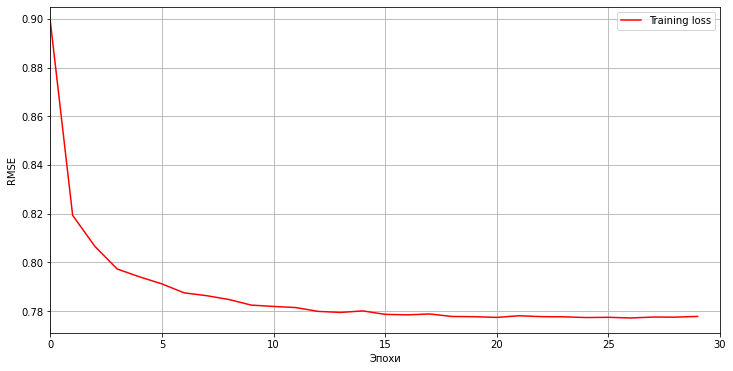

Loss:  0.7777847471333088


In [21]:
# Train
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
nepochs = 30

scheduler = StepLR(optimizer, step_size=3, gamma = 0.5)

train_func = train(model, criterion, optimizer,
                  train_loader, n_epochs=nepochs)

In [22]:
# Test 
set_random_seed(1984)
criterion = nn.MSELoss()
test(model, criterion, test_loader)

Test loss: 8.829621421028941
